In [2]:
import os
import sys
import mne
from facet.facet import facet
from loguru import logger
from mne.annotations import Annotations
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import scale_eeg_to, extract_spike_windows
from facet.Epilepsy.correlation_utils import  quick_spike_overview,find_best_ica,  compute_spike_regressors, list_top_spike_channels,  plot_ica_with_annotations
from facet.Epilepsy.shared_utils import build_template
import scipy.stats as st
from scipy.signal import find_peaks
from scipy.io import loadmat
import mne
import numpy as np

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

f = facet()

▶ Before filtering: max ≈ 6227.9 µV, min ≈ -3079.8 µV
▶ After filtering:  max ≈ 2212.7 µV, min ≈ -2249.2 µV


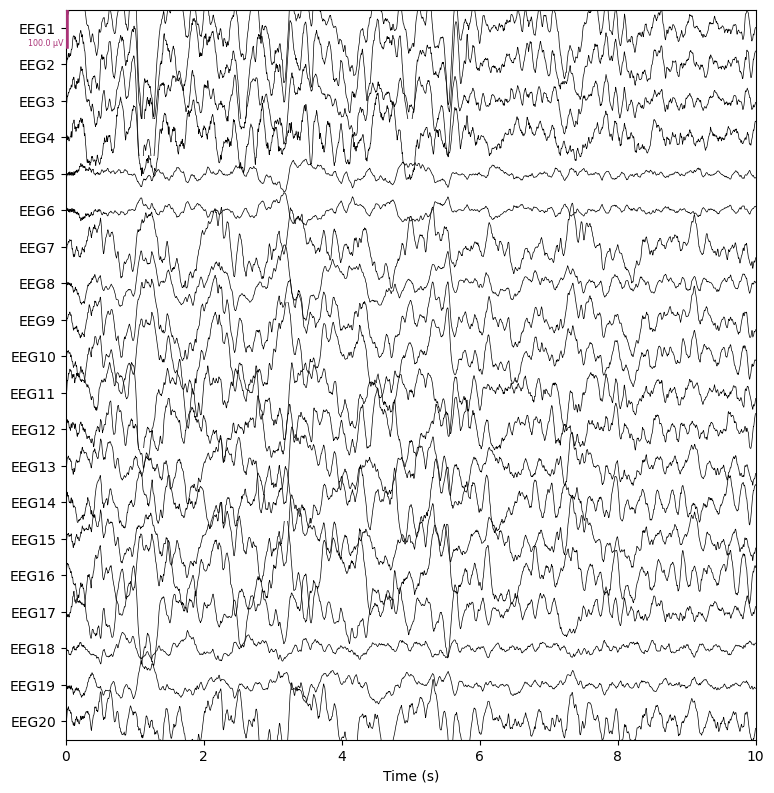

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat

# 1) Load the .mat file
path = r"G:\Medical Engineering and Analytics\Project\FACETpy\examples\datasets\MAT_Files\DA00100V.mat"

mat = loadmat(path)
eeg = mat['eeg_data']  # shape (n_ch, n_samples), raw numbers   
# 2) Build an MNE RawArray in volts
sfreq   = 500.0  # Hz
ch_names = [f"EEG{i+1}" for i in range(eeg.shape[0])]
info     = mne.create_info(ch_names, sfreq, ch_types="eeg")
raw      = mne.io.RawArray(eeg, info)

# 3) Print basic stats in µV
before_max_uv = raw.get_data().max() * 1e6
before_min_uv = raw.get_data().min() * 1e6
print(f"▶ Before filtering: max ≈ {before_max_uv:.1f} µV, min ≈ {before_min_uv:.1f} µV")

# 4) Notch + band-pass (all in volts!)
raw.notch_filter([50, 100], picks="eeg", verbose=False)
raw.filter(1.0, 70.0, picks="eeg", verbose=False)

# 5) Print stats *after* filtering (still in volts internally)
after_max_uv = raw.get_data().max() * 1e6
after_min_uv = raw.get_data().min() * 1e6
print(f"▶ After filtering:  max ≈ {after_max_uv:.1f} µV, min ≈ {after_min_uv:.1f} µV")


# 7) MNE browser with a fixed  µV scale
scalings = {"eeg": 50e-6}
raw.plot(duration=10, scalings=scalings, show_scrollbars=False)
plt.close("all")


### PRINT annotation times

In [4]:

events = mat['events']
for row in events:
    time_str, _, label = row
    print("Label:", label, "at time (s):", float(time_str))


Label: Sleeping                         at time (s): 0.45
Label: !                                at time (s): 35.706
Label: !                                at time (s): 53.14
Label: !                                at time (s): 78.78
Label: !                                at time (s): 112.38
Label: !                                at time (s): 144.548
Label: !                                at time (s): 145.182
Label: !                                at time (s): 187.222
Label: !                                at time (s): 231.82
Label: !                                at time (s): 311.02
Label: Sleeping                         at time (s): 323.88
Label: !                                at time (s): 359.16
Label: !                                at time (s): 425.85
Label: !                                at time (s): 431.05
Label: !                                at time (s): 448.814
Label: !                                at time (s): 457.686
Label: Sleeping                        

### MANUALLY SLICE SPIKE WINDOW

found 52 spikes


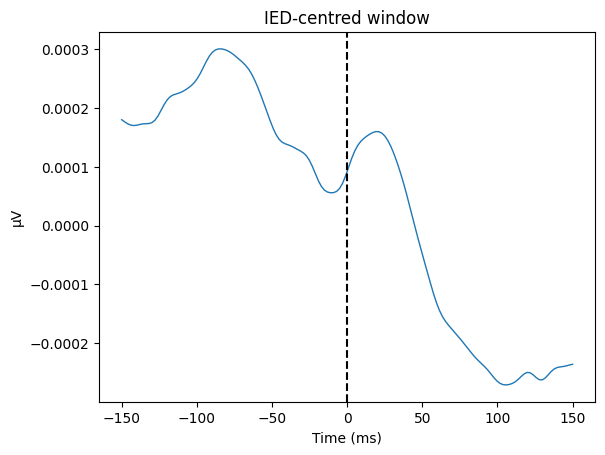

segments.shape = (52, 150)


In [5]:

chan_idx   = 0      # channel you want
half_win_s = 0.15   # 100 ms before & after the spike

# grab the spike times (seconds) 
events = mat["events"]
spike_sec = [float(r[0]) for r in events if r[2].strip() == "!"]
print(f"found {len(spike_sec)} spikes")

# extract windows
segments, times = extract_spike_windows(raw, spike_sec, chan_idx, half_win_s)
print("segments.shape =", segments.shape)


### TOP SPIKE CHANNEL BY AMPLITUDE

In [6]:
import numpy as np
raw = scale_eeg_to(raw, "uV")  

# List the 5 best channels (index, name, mean P–P in µV)
top5 = list_top_spike_channels(raw, spike_sec, half_win_s=0.15, top_n=5)

print("Top channels by spike amplitude:")
for idx, name, pp in top5:
    print(f"  {idx:2d} : {name:<10s} : {pp:.1f} µV")


Scaling EEG from volts → microvolts.
Top channels by spike amplitude:
  23 : EEG24      : 980.3 µV
   1 : EEG2       : 488.0 µV
  26 : EEG27      : 471.2 µV
  24 : EEG25      : 447.2 µV
   0 : EEG1       : 431.4 µV


### SPIKE OVERVIEW SELECTED CHANNELS

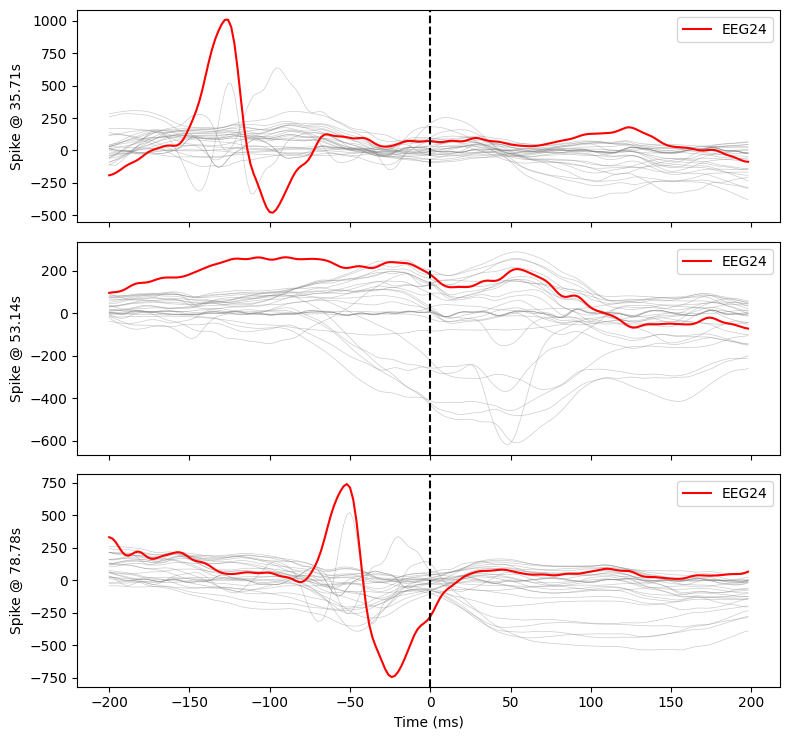

In [7]:
quick_spike_overview(raw, spike_sec, highlight_ch=23,
                     window_s=0.4, n_spikes=3)

### SPIKE OVERVIEW BAD CHANNELS?

In [ ]:
for ch in [25,26,27,28]:      # zero-based indices for EEG 26–29
    print(f"\n===== CHANNEL {ch} : {raw.ch_names[ch]} =====")
    quick_spike_overview(raw, spike_sec, 
                         highlight_ch=ch, 
                         window_s=0.4, 
                         n_spikes=3)

### BUILD TEMPLATE

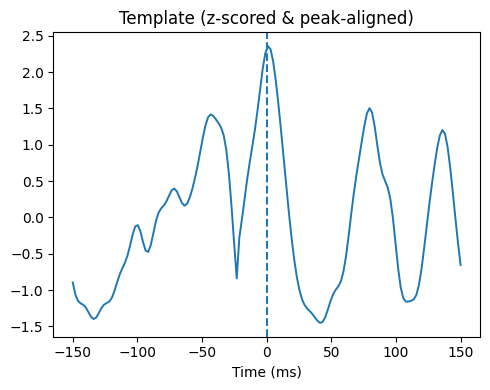

In [7]:
best_ch, template_z, half_shift = build_template(raw, spike_sec, half_win_s=0.15)

### CORRELATION ICA

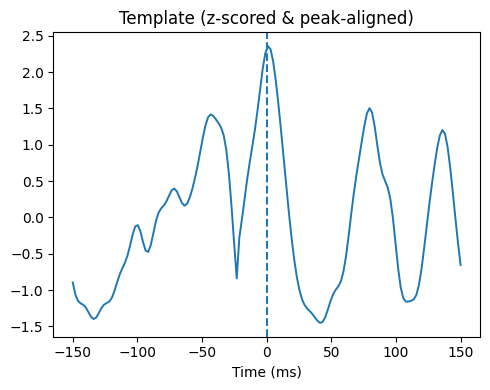

In [ ]:

# run  existing pipeline *unchanged*, with th_ica=0.85:
template_z, r_raw, r_ica, peaks_raw, peaks_ica, best_ch, best_ica_idx, caught, missed = \
    compute_spike_regressors(raw, spike_sec,
                             half_win_s=0.15,
                             th_raw=0.35, th_ica=0.70,
                             min_dist_s=0.3,
                             match_tol_s=0.1)

det_times = peaks_ica / sfreq

# true positives: any det_time within ±tol of any manual time
tol = 0.1
true_pos = [t for t in det_times
            if any(abs(t - s) <= tol for s in spike_sec)]
false_pos = [t for t in det_times
             if all(abs(t - s) > tol for s in spike_sec)]

print(f"True positives  : {len(true_pos)} detections at {true_pos}")
print(f"False positives : {len(false_pos)} detections at {false_pos[:10]}…")


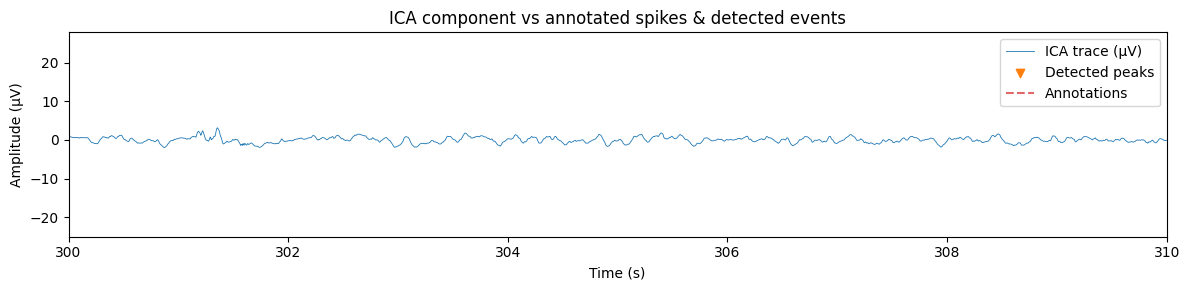

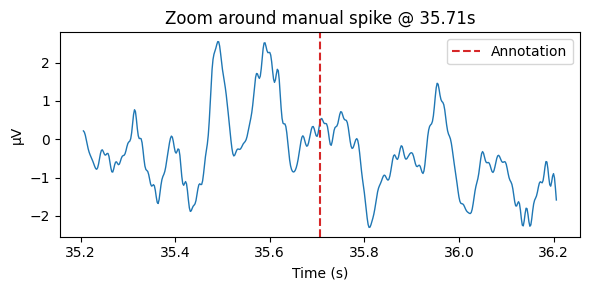

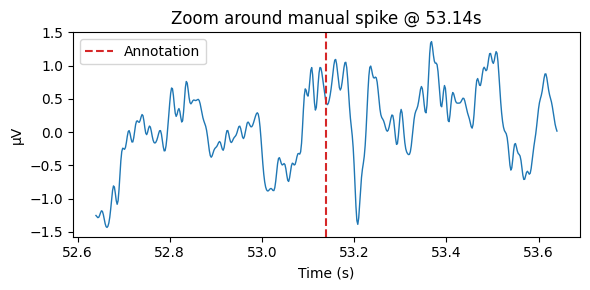

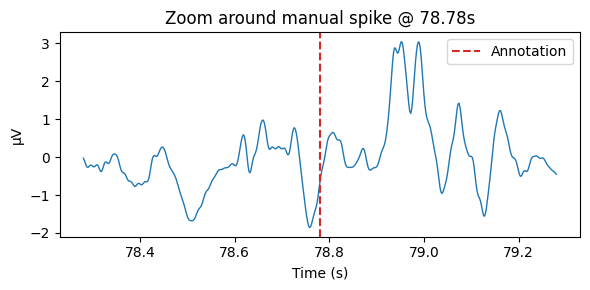

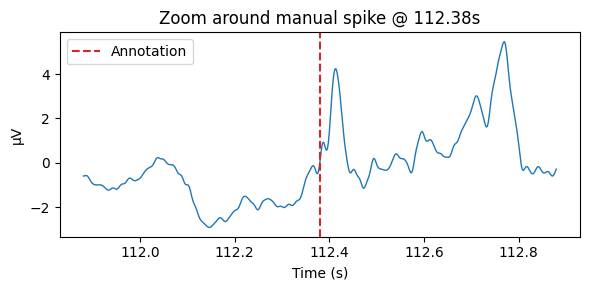

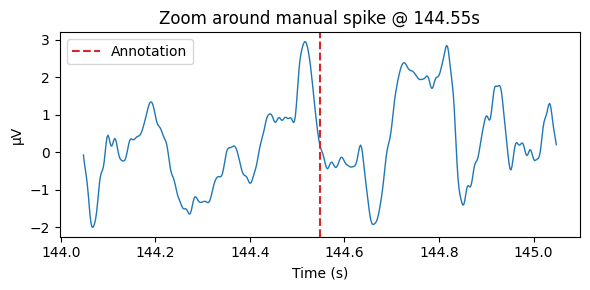

In [10]:
# get the ICA time series in µV
_, ica_trace, _ = find_best_ica(raw, template_z, half_shift)

# now plot
plot_ica_with_annotations(raw, ica_trace, peaks_ica, spike_sec,
                          match_tol_s=0.1, tmin=300, tmax=310)

### MANUAL INSPECTION

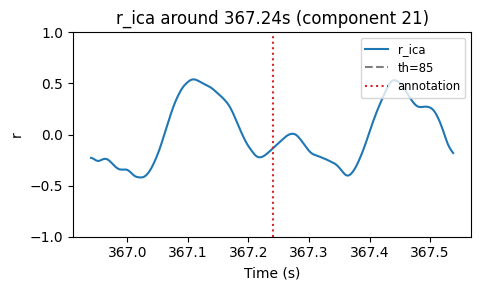

r_ica at 367.24s = -0.136  (threshold is 85)


In [11]:
sfreq = raw.info['sfreq']
times = np.arange(len(r_ica)) / sfreq

# 2) find the index of your manual spike
t_man   = 367.24
idx_man = int(round(t_man * sfreq))

# 3) extract a ±0.3 s window around that index
win_s    = 0.3
half_samp= int(win_s * sfreq)
sel      = slice(idx_man - half_samp, idx_man + half_samp)

# 4) plot r_ica there
plt.figure(figsize=(5,3))
plt.plot(times[sel], r_ica[sel], label='r_ica')
plt.axhline(85, color='gray', ls='--', label=f'th={85}')
plt.axvline(t_man, color='C3', ls=':', label='annotation')
plt.ylim(-1,1)
plt.xlabel('Time (s)')
plt.ylabel('r')
plt.legend(loc='upper right', fontsize='small')
plt.title(f"r_ica around {t_man}s (component {best_ica_idx})")
plt.tight_layout()
plt.show()

# 5) print the exact correlation at the annotated time
print(f"r_ica at {t_man}s = {r_ica[idx_man]:.3f}  (threshold is {85})")